# Doble Pozo

In [1]:
import numpy as np
import h5py as h5py
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

In [2]:
plt.style.use('ggplot')

# Definición del sistema

In [3]:
system = mm.System()
mass   = 35.453 * unit.amu # masa del átomo Cl
system.addParticle(mass)

0

# Paisaje Energía Potencial

Doble pozo, simétrico o asimétrico.

### Pozo harmónico en Y y Z

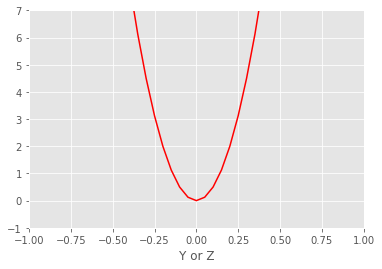

In [4]:
# '0.5*K*x**2'

def harmonic_well(x,K):
    return 0.5*K*x**2

K=100.0

x_serie = np.arange(-5., 5., 0.05)
plt.rcParams['figure.figsize'] = 6,4
plt.plot(x_serie, harmonic_well(x_serie,K), 'r-')
plt.ylim(-1,7)
plt.xlim(-1,1)
plt.xlabel("Y or Z")
plt.show()

Calculamos el periodo de oscilación natural para tener referencia temporal para la elección del paso de integración.

$m\frac{d^2 x}{dt^2} = -kx$

$x = A\cos{\omega t+\phi}$

$\omega = \sqrt{\frac{k}{m}} = \frac{2\pi}{T}$

$T = 2\pi \sqrt{\frac{m}{k}}$




In [5]:
x = sy.symbols('x')
f=0.5*K*x**2
g=sy.diff(f,x)
gg=sy.diff(f,x,x)
roots_diff=sy.roots(g,x)

print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

roots_yz=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_yz.append(root)
        T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
        print('Minimo en coordenada',root,'con k effectiva',effective_k,' y un periodo T de oscilación',T)

Calculamos las raices:

Función: 50.0*x**2
Primera derivada: 100.0*x
Segunda derivada: 100.000000000000
Minimo en coordenada 0 con k effectiva 100.000000000000  y un periodo T de oscilación 0.18289866089177864 ps


### Doble pozo en X

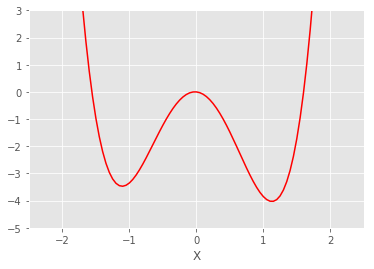

In [6]:
# 'Eo(C*x**4-x**2)+M*x'

def double_well(x,Eo,C,M):
    return Eo*(C*x**4-x**2)+M*x

Eo=6.0
C=0.4
M=-0.25 # Factor de asimetricidad.

x_serie = np.arange(-5., 5., 0.05)

plt.rcParams['figure.figsize'] = 6,4
plt.plot(x_serie, double_well(x_serie,Eo,C,M), 'r-')
plt.ylim(-5,3)
plt.xlim(-2.5,2.5)
plt.xlabel("X")
plt.show()

Calculamos el periodo de oscilación natural en lo mínimos, en su aproximación de pequeñas oscilaciones harmónicas, para tener referencia temporal para la elección del paso de integración.

In [7]:
x = sy.symbols('x')
f = Eo*(C*x**4-x**2)+M*x

g=sy.diff(f,x)
gg=sy.diff(f,x,x)
roots_diff=sy.roots(g,x)

print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

roots_x=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_x.append(root)
        T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
        print('Minimo en coordenada',root,'con k effectiva',effective_k,' y un periodo T de oscilación',T)

Calculamos las raices:

Función: 2.4*x**4 - 6.0*x**2 - 0.25*x
Primera derivada: 9.6*x**3 - 12.0*x - 0.25
Segunda derivada: 28.8*x**2 - 12.0
Minimo en coordenada -1.10746801335942 con k effectiva 23.3227795376907  y un periodo T de oscilación 0.3787218588759126 ps
Minimo en coordenada 1.12830858803474 con k effectiva 24.6647117711887  y un periodo T de oscilación 0.3682752249030117 ps


### Añadiendo el potencial al sistema

In [8]:
force = mm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')
force.addGlobalParameter('K', K * unit.kilocalories_per_mole/unit.angstrom**2)
force.addGlobalParameter('Eo', Eo * unit.kilocalories_per_mole/unit.angstrom**2)
force.addGlobalParameter('C', C * 1/unit.angstrom**2)
force.addGlobalParameter('M', M * unit.kilocalories_per_mole/unit.angstrom)
force.addParticle(0, [])
system.addForce(force)

0

# Estado termodinámico

In [9]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

# Parámetros de la simulación

In [10]:
step_size       = 0.01*unit.picoseconds
num_steps       = 4000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

# Integrador

In [11]:
friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Plataforma de simulación

In [12]:
platform_name = 'CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)

# Reporteros y arrays de salida

In [13]:
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

# Condiciones iniciales

In [14]:
initial_positions  = [[roots_x[0], roots_yz[0], roots_yz[0]]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [15]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Corriendo la simulación

In [16]:
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 40000/40000 [11:01<00:00, 60.43it/s]


# Análisis de resultados

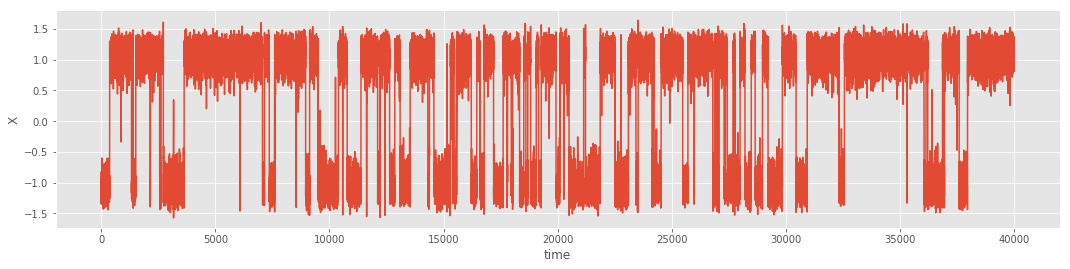

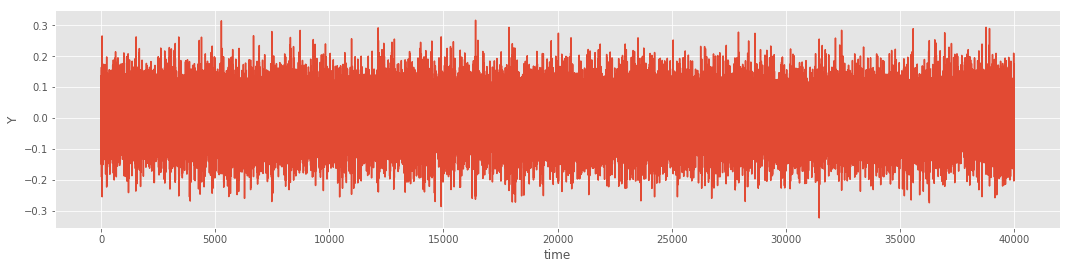

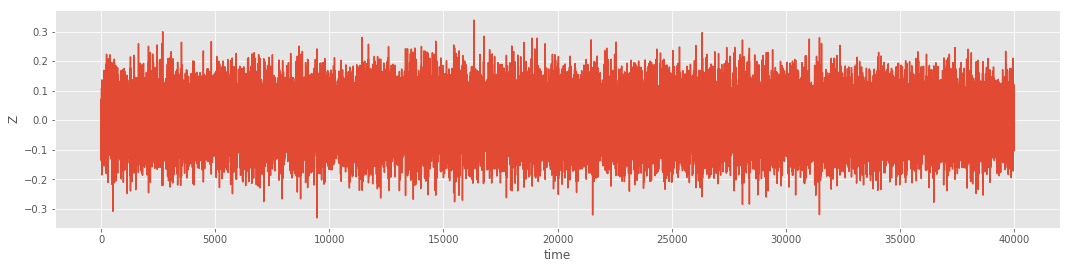

In [17]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

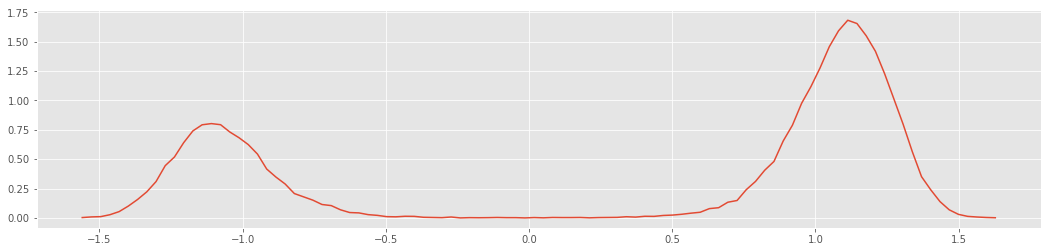

In [18]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

/home/diego/Myusr/opt/miniconda3/envs/academia/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


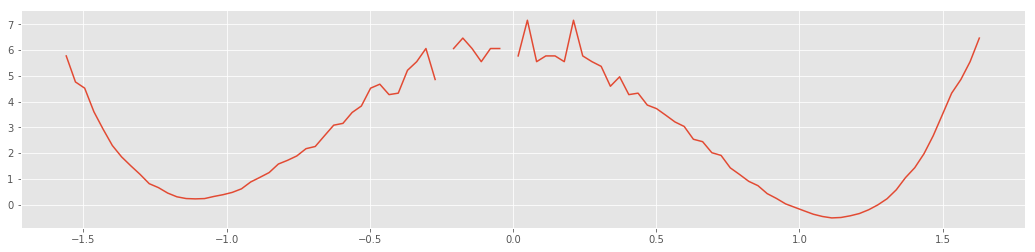

In [19]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

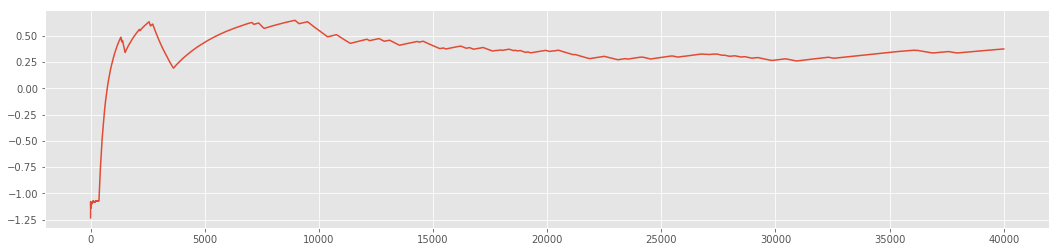

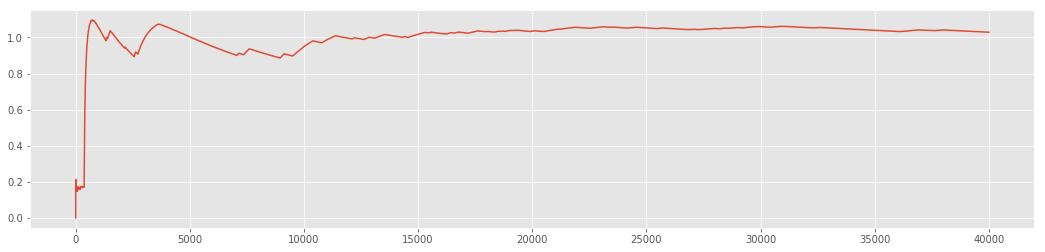

In [20]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [21]:
writing = False

if writing: 
    h5f = h5py.File('data_double_well_md.h5', 'w')
    h5f.create_dataset('times', data=times)
    h5f.create_dataset('positions', data=positions)
    h5f.create_dataset('velocities', data=velocities)
    h5f.create_dataset('kinetic_energies', data=kinetic_energies)
    h5f.create_dataset('potential_energies', data=potential_energies)
    h5f.close()

In [22]:
reading =False

if reading:
    h5f = h5py.File('data_double_well_md.h5', 'r')
    #for name in h5f:
    #    print(name)
    times              = h5f['times'][:]
    positions          = h5f['positions'][:]
    velocities         = h5f['velocities'][:]
    kinetic_energies   = h5f['kinetic_energies'][:]
    potential_energies = h5f['potential_energies'][:]
    h5f.close()

In [23]:
"""
T = sqrt(m/K)
timestep smaller than ~ T/10
standard deviation in each dimension sigma= (kT / K)^(1/2)
Expectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT
"""

'\nT = sqrt(m/K)\ntimestep smaller than ~ T/10\nstandard deviation in each dimension sigma= (kT / K)^(1/2)\nExpectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT\n'